In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from tqdm import tqdm
from models import RNNGC
from dataset import DatasetMaker

In [2]:
## Training parameters
train_steps = 100000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units

In [3]:
alpha = 0.5
rayleigh_scale = 0.15*5

In [ ]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC() #alpha = alpha

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [5]:
dataset = DatasetMaker(rayleigh_scale = rayleigh_scale)
dataset.rayleigh_scale

0.75

(-6.283185307179586, 6.283185307179586, -6.283185307179586, 6.283185307179586)

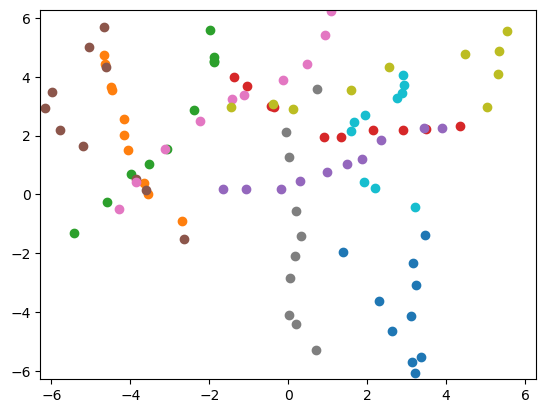

In [6]:
rt, vt = dataset.generate_data(10, timesteps, "cpu")

for i in range(10):
  plt.plot(rt[i,...,0], rt[i,...,1], "o")
plt.axis(2*np.pi*np.array([-1, 1, -1, 1]))

In [7]:
loss_history = []
for i in tqdm(range(train_steps-len(model.total_loss_history))):
    r, v = dataset.generate_data(bs, timesteps, device)

    loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)
    loss_history.append(loss.item())
model.save(f"../saved-models/RNNGC_{i}_alpha_{model.alpha}_rayleigh_scale_{rayleigh_scale}.pkl")

100%|██████████| 100000/100000 [19:28<00:00, 85.58it/s]


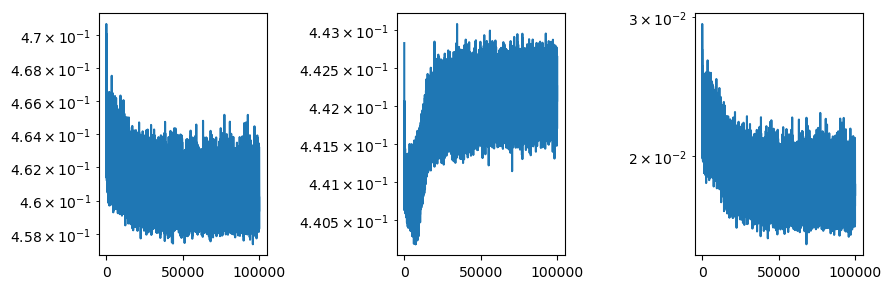

In [8]:
fig,axs = plt.subplots(1,3,figsize=(9,3))
axs[0].semilogy(np.array(model.total_loss_history)-model.loss_minima())
axs[1].semilogy(np.array(model.capacity_loss_history)-model.loss_minima())
axs[2].semilogy(model.distance_loss_history)
fig.tight_layout()

In [9]:
r, v = dataset.generate_data(100000, timesteps, device)
g = model((r[:,0], v))

r = r.detach().cpu().numpy()
g = g.detach().cpu().numpy()

In [10]:
ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

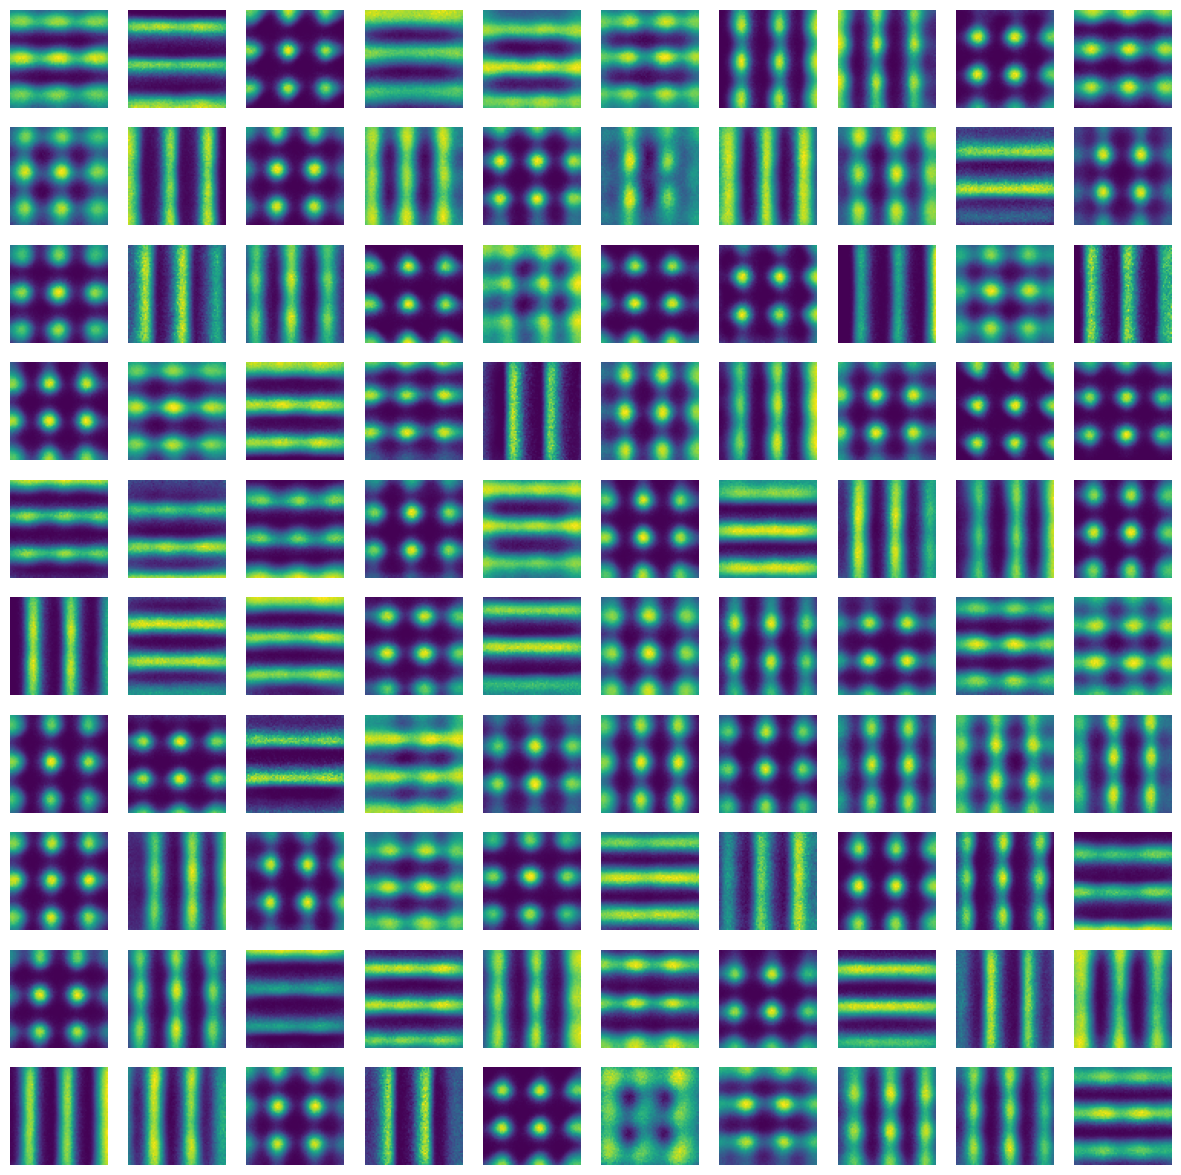

In [11]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1

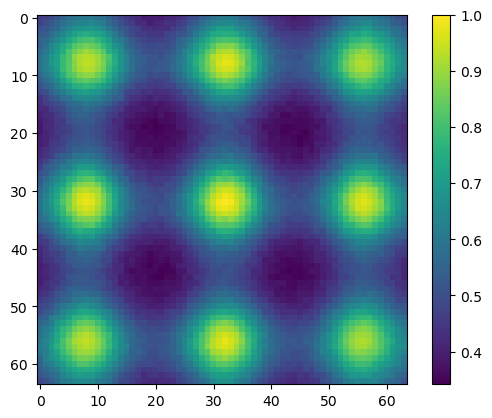

In [12]:
sim = np.exp(np.sum(-(ratemaps - ratemaps[:,32,32][:,None,None])**2, axis = 0))
plt.imshow(sim) # spatial similarity with origin
plt.colorbar()

In [13]:
model.alpha

0.54

In [14]:
dataset.rayleigh_scale

0.75